In [ ]:
!pip install tensorflow datasets matplotlib seaborn scikit-learn pillow flask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00


In [ ]:
# Importation des bibliotheques necessaires
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from datasets import load_dataset
from PIL import Image
import io
import os
import flask
from flask import Flask, request, jsonify

In [ ]:
from datasets import load_dataset

# Charger le dataset
dataset = load_dataset("PedroSampaio/fruits-360")

# Afficher les informations du dataset
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.58k [00:00<?, ?B/s]

(…)-00000-of-00001-086dc013443c484c.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

(…)-00000-of-00001-0d294abe3826b2e6.parquet:   0%|          | 0.00/98.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67690 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22688 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 67690
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 22688
    })
})


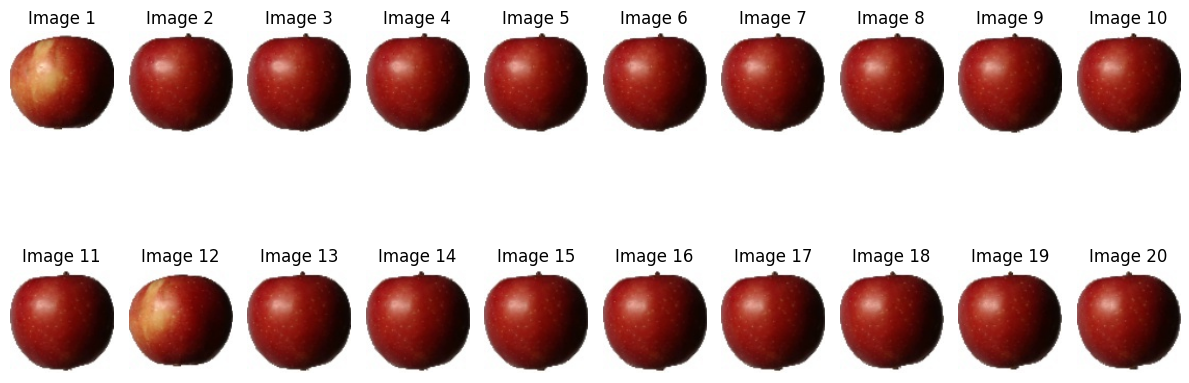

In [ ]:
# Appercu du dataset
import matplotlib.pyplot as plt

# Afficher les 10 premières images du dataset d'entraînement
fig, axes = plt.subplots(2, 10, figsize=(12, 6))  # 2 lignes, 5 colonnes

for i, ax in enumerate(axes.flat):
    image = dataset['train'][i]['image']  # Récupérer l'image
    ax.imshow(image)
    ax.set_title(f"Image {i+1}")  # Ajouter un titre avec l'index
    ax.axis("off")  # Cacher les axes

plt.tight_layout()
plt.show()

In [ ]:
# Affichage des informations du dataset
print("Clés du dataset:", dataset.keys())
print("Nombre d'images dans l'ensemble d'entraînement:", len(dataset["train"]))
print("Nombre d'images dans l'ensemble de test:", len(dataset["test"]))


Clés du dataset: dict_keys(['train', 'test'])
Nombre d'images dans l'ensemble d'entraînement: 67690
Nombre d'images dans l'ensemble de test: 22688


In [ ]:
type(dataset['train'][0]['image'])

PIL.JpegImagePlugin.JpegImageFile

In [ ]:
# Obtenir les classes (labels)
classes = dataset["train"].features["label"].names
num_classes = len(classes)
print(f"Nombre de classes: {num_classes}")
print(f"Exemples de classes: {classes[:5]}")

Nombre de classes: 113
Exemples de classes: ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden', 'Apple Granny Smith', 'Apple Pink Lady']


In [ ]:
# Créer des dossiers temporaires pour stocker les images
import tempfile
import shutil
import os

# Créer des répertoires pour chaque classe
def create_image_folders(dataset_split, base_dir):
    os.makedirs(base_dir, exist_ok=True)

    # Créer un dossier pour chaque classe
    for class_name in classes:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

    # Sauvegarder les images dans leurs dossiers respectifs
    for i, example in enumerate(dataset_split):
        img = example["image"]
        label_id = example["label"]
        class_name = classes[label_id]

        # Sauvegarder l'image
        img_path = os.path.join(base_dir, class_name, f"img_{i}.jpg")
        img.save(img_path)

    return base_dir

In [ ]:
# Créer les dossiers temporaires
train_dir = tempfile.mkdtemp(prefix="train_")
test_dir = tempfile.mkdtemp(prefix="test_")

In [ ]:
print("Préparation des données d'entraînement...")
create_image_folders(dataset["train"], train_dir)
print("Préparation des données de test...")
create_image_folders(dataset["test"], test_dir)

Préparation des données d'entraînement...
Préparation des données de test...


'/tmp/test_4bmhsxcx'

In [ ]:
# Configuration des générateurs d'images pour la normalisation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Création des générateurs de données
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 67690 images belonging to 113 classes.
Found 22688 images belonging to 113 classes.


In [ ]:
# Charger le modèle VGG16 pré-entraîné sans la couche supérieure
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Geler toutes les couches sauf celles du bloc5_conv
for layer in base_model.layers:
    if "block5" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Ajouter des couches de classification au-dessus du modèle pré-entraîné
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 113)                 │          57,969 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,618,225 (105.36 MB)

 Trainable params: 19,982,961 (76.23 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Compiler le modèle
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Définir des callbacks pour améliorer l'entraînement
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Calculer le nombre d'étapes par époque
steps_per_epoch = len(train_generator)
validation_steps = len(test_generator)

# Entraîner le modèle avec les générateurs
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=50,
    validation_data=test_generator,
    validation_steps=50,
    callbacks=[checkpoint, early_stopping]
)


# Sauvegarde des hyperparamètres
with open("models/config.json", "w") as f:
    json.dump(config, f)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9705 - loss: 0.1022
Epoch 1: val_accuracy improved from -inf to 0.94750, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 469ms/step - accuracy: 0.9706 - loss: 0.1020 - val_accuracy: 0.9475 - val_loss: 0.1608
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9770 - loss: 0.0916
Epoch 2: val_accuracy improved from 0.94750 to 0.95250, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 754ms/step - accuracy: 0.9770 - loss: 0.0914 - val_accuracy: 0.9525 - val_loss: 0.1689
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9755 - loss: 0.0979
Epoch 3: val_accuracy did not improve from 0.95250
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.9755 - loss: 0.0978 - val_accuracy: 0.9513 - val_loss: 0.1334
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9860 - loss: 0.0488
Epoch 4: val_accuracy improved from 0.95250 to 0.96812, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - accuracy: 0.9859 - loss: 0.0489 - val_accuracy: 0.9681 - val_loss: 0.1083
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9776 - loss: 0.0993
Epoch 5: val_accuracy did not improve from 0.96812
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9776 - loss: 0.0987 - val_accuracy: 0.9519 - val_loss: 0.1451
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9826 - loss: 0.0653
Epoch 6: val_accuracy improved from 0.96812 to 0.98250, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 434ms/step - accuracy: 0.9826 - loss: 0.0653 - val_accuracy: 0.9825 - val_loss: 0.0751
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9813 - loss: 0.0566
Epoch 7: val_accuracy did not improve from 0.98250
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9813 - loss: 0.0566 - val_accuracy: 0.9550 - val_loss: 0.1272
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9861 - loss: 0.0498
Epoch 8: val_accuracy did not improve from 0.98250
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 373ms/step - accuracy: 0.9861 - loss: 0.0501 - val_accuracy: 0.9575 - val_loss: 0.1789
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9932 - loss: 0.0473
Epoch 9: val_accuracy improved from 0.98250 to 0.98312, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 431ms/step - accuracy: 0.9932 - loss: 0.0471 - val_accuracy: 0.9831 - val_loss: 0.0606
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9812 - loss: 0.0480
Epoch 10: val_accuracy did not improve from 0.98312
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 365ms/step - accuracy: 0.9812 - loss: 0.0483 - val_accuracy: 0.9619 - val_loss: 0.0959
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9825 - loss: 0.0798
Epoch 11: val_accuracy did not improve from 0.98312
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.9825 - loss: 0.0795 - val_accuracy: 0.9681 - val_loss: 0.0941
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9963 - loss: 0.0241
Epoch 12: val_accuracy did not improve from 0.98312
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - accuracy: 0.9961 - loss: 0.0243 - val_accuracy: 0.9819 - val_loss: 0.0620
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 9.


FileNotFoundError: [Errno 2] No such file or directory: 'models/config.json'

In [ ]:
len(train_generator)

2116

In [ ]:
# Évaluer le modèle sur l'ensemble de test
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4%}")


480/709 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.9434 - loss: 0.2021

ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/werkzeug/local.py", line 318, in __get__
    obj = instance._get_current_object()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/werkzeug/local.py", line 519, in _get_current_object
    raise RuntimeError(unbound_message) from None
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request. Consult the documentation on testing for
information about how to avoid this problem.


486/709 ━━━━━━━━━━━━━━━━━━━━ 36s 165ms/step - accuracy: 0.9433 - loss: 0.2025

ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/werkzeug/local.py", line 318, in __get__
    obj = instance._get_current_object()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/werkzeug/local.py", line 519, in _get_current_object
    raise RuntimeError(unbound_message) from None
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request. Consult the documentation on testing for
information about how to avoid this problem.


559/709 ━━━━━━━━━━━━━━━━━━━━ 24s 165ms/step - accuracy: 0.9424 - loss: 0.2057

ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/werkzeug/local.py", line 318, in __get__
    obj = instance._get_current_object()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/werkzeug/local.py", line 519, in _get_current_object
    raise RuntimeError(unbound_message) from None
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request. Consult the documentation on testing for
information about how to avoid this problem.


709/709 ━━━━━━━━━━━━━━━━━━━━ 117s 165ms/step - accuracy: 0.9418 - loss: 0.2084
Test Loss: 0.2146
Test Accuracy: 94.2216%


In [ ]:
import numpy as np

# Prédire les classes des images du test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir en classes (si classification)

print("Prédictions des premières images :", y_pred_classes[:10])


709/709 ━━━━━━━━━━━━━━━━━━━━ 117s 165ms/step
Prédictions des premières images : [0 0 0 0 0 0 0 0 0 0]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Prédictions sur l'ensemble de test
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Matrice de confusion:")
print(conf_matrix)

# Rapport de classification
class_names = list(test_generator.class_indices.keys())
print("Rapport de classification:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

709/709 ━━━━━━━━━━━━━━━━━━━━ 117s 165ms/step
Matrice de confusion:
[[135   0   0 ...   0   0   0]
 [  0 148   0 ...   0   0   0]
 [  0   0 479 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]
Rapport de classification:
                     precision    recall  f1-score   support

     Apple Braeburn       0.83      0.82      0.83       164
 Apple Crimson Snow       0.86      1.00      0.93       148
       Apple Golden       0.99      0.99      0.99       485
 Apple Granny Smith       0.97      1.00      0.98       164
    Apple Pink Lady       0.97      0.93      0.95       152
          Apple Red       0.92      1.00      0.96       472
Apple Red Delicious       1.00      0.99      0.99       166
   Apple Red Yellow       0.99      0.93      0.96       383
            Apricot       0.99      1.00      1.00       164
            Avocado       0.99      0.98      0.99       143
       Avocado ripe       0.97      0.96  